






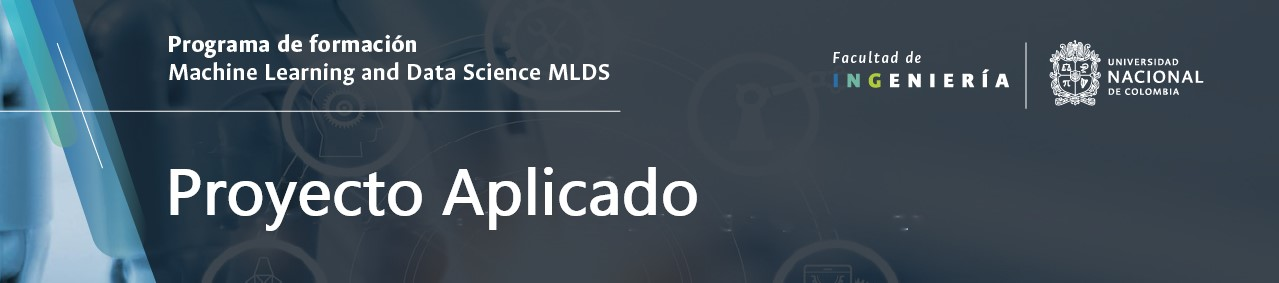

**Importar *librerías* a utilizar**

In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
import sklearn

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
!python --version
print('Pandas', pd.__version__)
print('NumPy', np.__version__)
print('Matplotlib', mpl.__version__)
print('missingno', msno.__version__)

Python 3.10.11
Pandas 1.5.3
NumPy 1.22.4
Matplotlib 3.7.1
missingno 0.5.2


Este material fue realizado con las siguientes versiones:

- Python: 3.10.11
- pandas: 1.5.3
- NumPy: 1.22.4
- Matplotlib: 3.7.1
- Missingno: 0.5.2

# **Diseño e implementación experimental**
---

## **3. Particion del conjunto de datos**
---

Vamos a preparar el *dataset* para el modelado. Nuestro objetivo es entrenar un **modelo autorregresivo**, en el cual el valor de la serie de tiempo en un momento dado $X_i$ depende de los $k$ valores anteriores.

La red neuronal debe tener $k$ entradas o *features* y $1$ salida, que corresponde al valor actual. Las *features* serán las $k$ observaciones previas, que corresponden a una **ventana** de tamaño $k$.

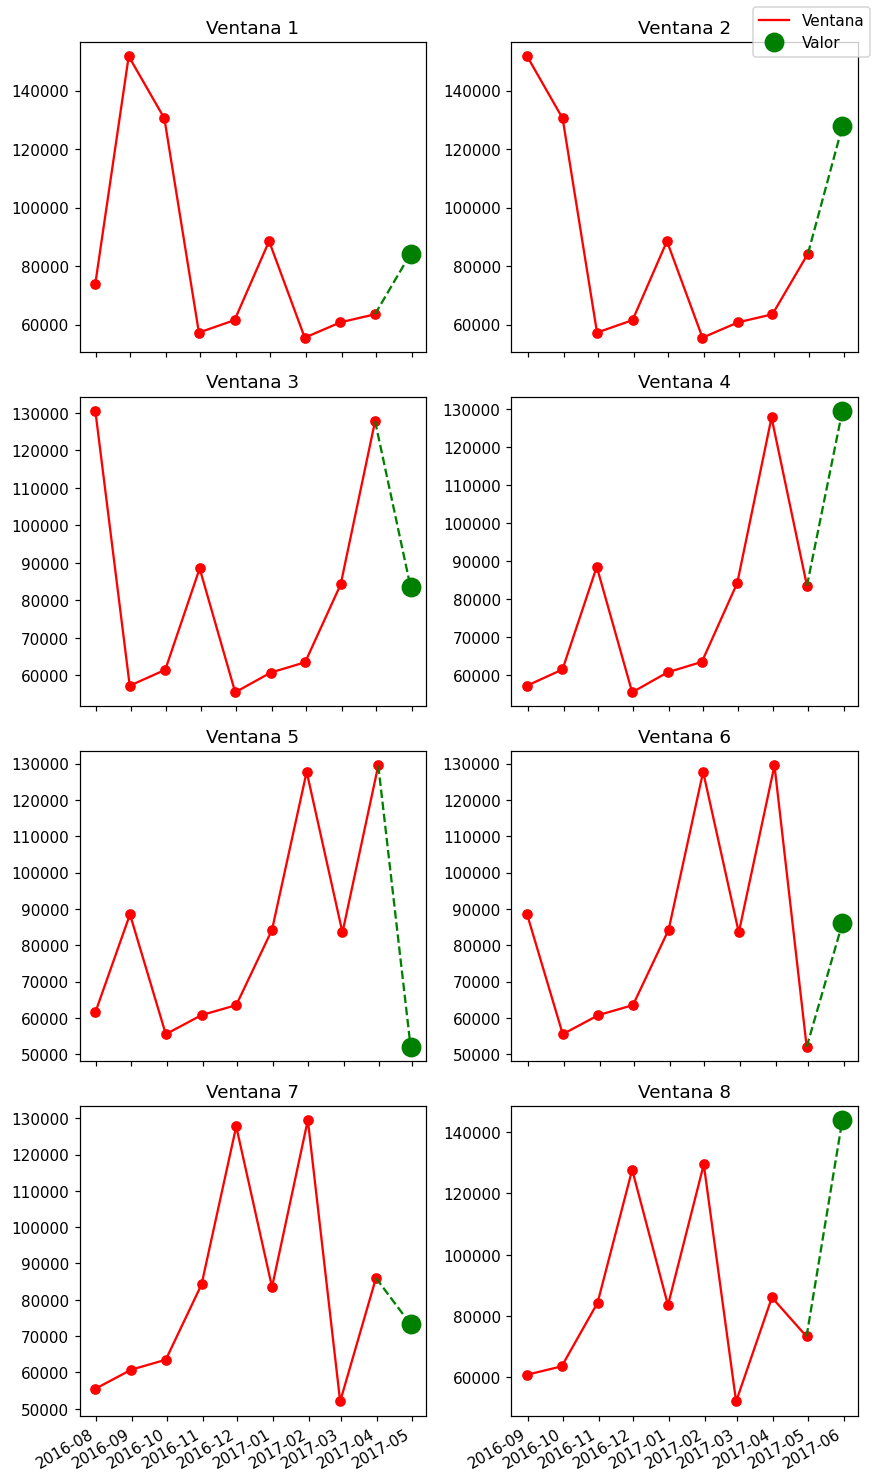

In [ ]:
#@markdown **Visualización:** Ventanas de tiempo.

#@markdown * **`n`**: Número de ventanas a visualizar.
n =   9#@param {type:"integer"}
#Visualización del concepto de ventana

#@markdown * **`k`**: Tamaño de la ventana.
k =   10#@param {type:"integer"}

fig, axes = plt.subplots(nrows = n//2, ncols= 2,  figsize = (8, 1.5*n), dpi = 110)

for i, ax in enumerate(axes.flat):
  data =  serie_ventas.iloc[i: i + k]
  ax.set_title(f'Ventana {i + 1}')
  ax.plot(data.index[:-1], data.values[:-1], 'r')
  ax.plot(data.index[-1], data.values[-1], 'go', ms = 12)
  ax.plot(data.index[:-1], data.values[:-1], 'ro')
  ax.plot(data.index[-2:], data.values[-2:], 'g--')
  fig.autofmt_xdate()
fig.tight_layout()

fig.legend(['Ventana', 'Valor']);

Para generar nuestro modelo vamos a iniciar con una ventana de tiempo de  6  observaciones.

## **3.1. Normalización de los datos**
---

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Realizaremos la normalización de los datos

serie_ventas = np.array(serie_ventas)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(serie_ventas.reshape(-1, 1))

In [ ]:
from sklearn.model_selection import train_test_split

# Realizamos la partición de los conjuntos de entrenamiento (60%), validación  (20%)y prueba (20%).

train_data, test_data = train_test_split(scaled_data, test_size=0.4, shuffle=False)
val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)

In [ ]:
# Tamaño de ventana o entrada del modelo

k = 6

# Número de meses a predecir o Salidas del modelo.

n_meses = 1


In [ ]:
# Creación de ventanas

def crear_ventanas(data, window_size, n_steps):
    X, y = [], []
    for i in range(len(data) - window_size - n_steps + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+n_steps])
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = crear_ventanas(train_data, k, n_meses)
X_val, y_val = crear_ventanas(val_data, k, n_meses)
X_test, y_test = crear_ventanas(test_data, k, n_meses)

In [ ]:
print(f'Datos:\n {X_train[0].flatten()}')
print(f'Predicción:\n{y_train[0]}')

Datos:
 [0.32628798 0.73712021 0.62483487 0.23778071 0.26023778 0.40290621]
Predicción:
[[0.22853369]]


In [ ]:
# Información sobre los conjuntos particionados.

print(f'Set de entrenamiento: {X_train.shape}, y_train: {y_train.shape}')
print(f'Set de validación: {X_val.shape}, y_val: {y_val.shape}')
print(f'Set de prueba: {X_test.shape}, y_test: {y_test.shape}')

Set de entrenamiento: (46, 6, 1), y_train: (46, 1, 1)
Set de validación: (12, 6, 1), y_val: (12, 1, 1)
Set de prueba: (12, 6, 1), y_test: (12, 1, 1)


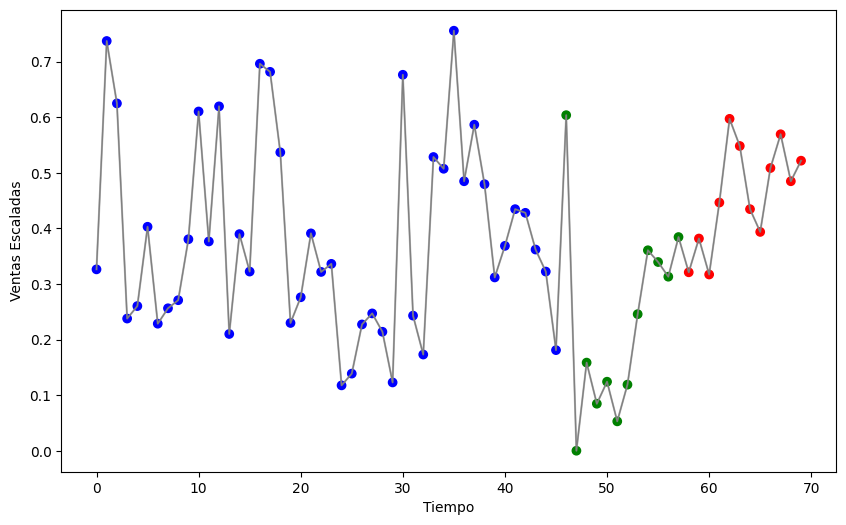

In [ ]:
# Visualizamos los conjuntos de datos

combined_data = np.concatenate((X_train, X_val, X_test), axis=0)
combined_labels = np.concatenate((y_train, y_val, y_test), axis=0)

total_data_points = combined_data.shape[0]

colors = ['blue'] * len(X_train) + ['green'] * len(X_val) + ['red'] * len(X_test)

plt.figure(figsize=(10, 6))
plt.plot(range(total_data_points), combined_data[:, 0, 0], color='gray', alpha=0.5)
plt.scatter(range(total_data_points), combined_data[:, 0, 0], c=colors)
plt.plot(range(total_data_points), combined_data[:, 0, 0], color='gray', linewidth=1)
plt.xlabel('Tiempo')
plt.ylabel('Ventas Escaladas')
plt.show()

## **3.2. Selección y diseño de modelos**
---

Basándonos en el conjunto de datos disponible, hemos determinado que el modelo más adecuado para abordar el problema que se nos presenta es un modelo de regresión. Las entradas de nuestro modelo estarán basadas en las ventas históricas mensuales de un producto específico del portafolio de la compañia, lo que implica que se trata de una serie de tiempo.

Dado lo anterior, hemos seleccionado una red neuronal recurrente LSTM para implementar en nuestro modelo. Esta elección se basa en la capacidad de las redes LSTM para manejar series de tiempo y predecir patrones de manera precisa. Con esta elección, esperamos obtener predicciones precisas y útiles que nos permitan tomar decisiones con información más precisa.

In [ ]:
# Definimos la arquitectura del modelo

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.activations import tanh

input_shape = (k, n_meses)
hidden_units = 64

input_layer = Input(shape=input_shape)
lstm_layer1 = LSTM(hidden_units, activation='tanh', return_sequences=True)(input_layer)
lstm_layer2 = LSTM(hidden_units, activation='tanh')(lstm_layer1)
output_layer = Dense(n_meses)(lstm_layer2)

model = Model(inputs=input_layer, outputs=output_layer)

En este modelo se utilizan dos capas de LSTM para mejorar la capacidad de aprendizaje de la red neuronal y capturar patrones complejos en la serie temporal.

La primera capa LSTM devuelve una secuencia completa de salidas para cada paso de tiempo en la serie temporal, que luego se utiliza como entrada para la segunda capa LSTM. La segunda capa LSTM produce una única salida que se alimenta a la capa de salida Dense, que predice la venta en el siguiente paso de tiempo.

Al utilizar dos capas LSTM, la red neuronal puede aprender a representar patrones complejos en la serie temporal. La primera capa LSTM puede capturar patrones a nivel local, mientras que la segunda capa LSTM puede aprender patrones a nivel global. Esto puede aumentar la precisión del modelo al predecir la venta en el siguiente paso de tiempo en la serie temporal.

In [ ]:
# Visualización del modelo

model.summary()

Model: "model_1874"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1875 (InputLayer)     [(None, 6, 1)]            0         
                                                                 
 lstm_3748 (LSTM)            (None, 6, 64)             16896     
                                                                 
 lstm_3749 (LSTM)            (None, 64)                33024     
                                                                 
 dense_1874 (Dense)          (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


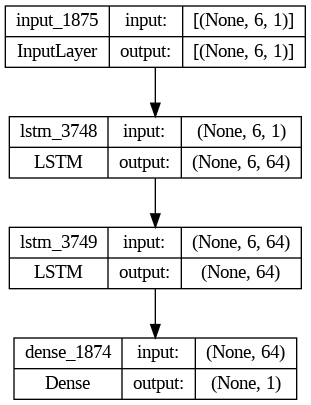

In [ ]:
# visualización diagramática del modelo

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Realizamos la compilación del modelo

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

optimizer = Adam(learning_rate=0.001)
loss = MeanSquaredError()

model.compile(optimizer=optimizer,
              loss=loss
              )

model.get_compile_config()

{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': True,
   'is_legacy_optimizer': False,
   'learning_rate': 0.0010000000474974513,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': {'module': 'keras.losses',
  'class_name': 'MeanSquaredError',
  'config': {'reduction': 'auto', 'name': 'mean_squared_error'},
  'registered_name': None},
 'metrics': None,
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'steps_per_execution': None,
 'jit_compile': None}

In [ ]:
# Definición de los callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('best_model.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=30,
                               verbose=1)

In [ ]:
# Entrenamiento del modelo

history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping]
                    )

Epoch 1/100
1/3 [=========>....................] - ETA: 7s - loss: 0.1991
Epoch 1: val_loss improved from inf to 0.03967, saving model to best_model.h5
3/3 [==============================] - 5s 453ms/step - loss: 0.1482 - val_loss: 0.0397
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0609
Epoch 2: val_loss improved from 0.03967 to 0.02129, saving model to best_model.h5
3/3 [==============================] - 0s 37ms/step - loss: 0.0921 - val_loss: 0.0213
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0840
Epoch 3: val_loss improved from 0.02129 to 0.01500, saving model to best_model.h5
3/3 [==============================] - 0s 38ms/step - loss: 0.0583 - val_loss: 0.0150
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0347
Epoch 4: val_loss did not improve from 0.01500
3/3 [==============================] - 0s 22ms/step - loss: 0.0410 - val_loss: 0.0248
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 0.0

In [ ]:
# Evaluar el modelo en el conjunto de prueba

mse = model.evaluate(X_test, y_test)
print("MSE:", mse)


1/1 [==============================] - 0s 29ms/step - loss: 0.0168
MSE: 0.016832225024700165


In [ ]:
# Cargar el mejor modelo
model.load_weights('best_model.h5')

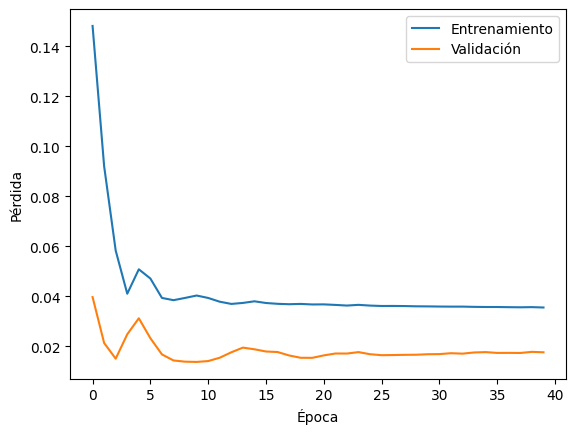

In [ ]:
# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
print(y_pred)

1/1 [==============================] - 1s 745ms/step
[[0.34139532]
 [0.3570303 ]
 [0.36298266]
 [0.37602785]
 [0.38157138]
 [0.3736256 ]
 [0.37132922]
 [0.37239546]
 [0.36347267]
 [0.3584108 ]
 [0.3516793 ]
 [0.34950027]]


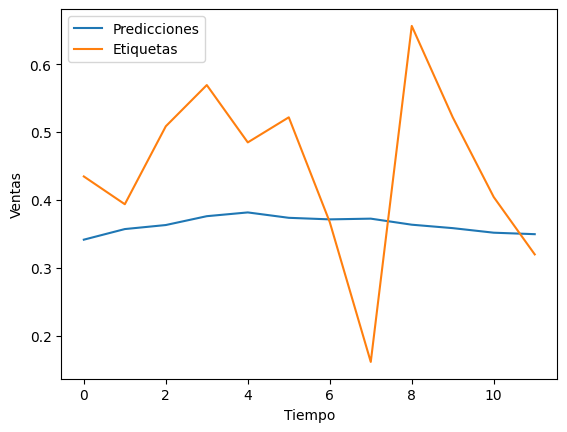

In [ ]:
# Graficar las predicciones y las etiquetas
plt.plot(y_pred.flatten(), label='Predicciones')
plt.plot(y_test.flatten(),label='Etiquetas')
plt.xlabel('Tiempo')
plt.ylabel('Ventas')
plt.legend()
plt.show()

In [ ]:
# Métricas de rendimiento
# Error absoluto, cuadrado, y cuadrado logarítmico.
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

y_pred = model.predict(X_test)

y_test = np.reshape(y_test, (-1, 1))
y_pred = np.reshape(y_pred, (-1, 1))

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_pred):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test Mean squared log error: \t{mean_squared_log_error(y_test, y_pred):.4f}")

1/1 [==============================] - 0s 28ms/step
Test Mean Squared Error: 	0.0244
Test Mean Absolute Error: 	0.1288
Test Mean squared log error: 	0.0122


In [ ]:
# Desnormalizar las predicciones y las etiquetas
y_pred = scaler.inverse_transform(y_pred.reshape(-1, n_meses))
y_test = scaler.inverse_transform(y_test.reshape(-1, n_meses))

In [ ]:
print(y_pred)

[[81358.38 ]
 [83098.27 ]
 [84376.7  ]
 [84947.5  ]
 [82570.48 ]
 [81331.836]
 [81118.67 ]
 [81218.984]]
